In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [3]:
IMG_SIZE = 224

In [4]:
def load_img(path):
    image = cv2.imread(path)
    return image

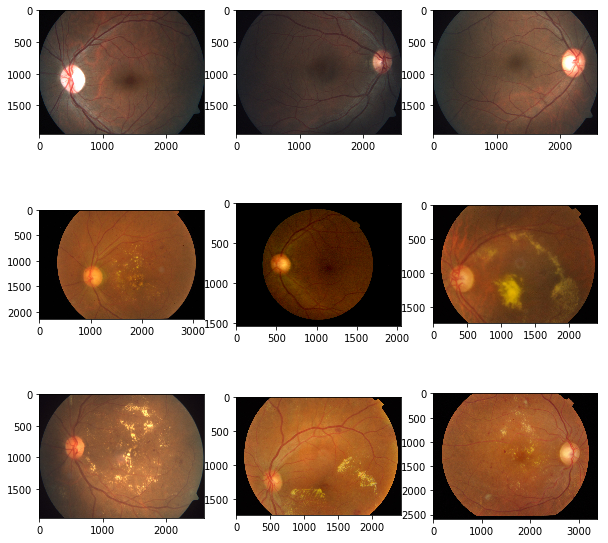

In [5]:
fig, axes = plt.subplots(3,3,figsize=(10,10))
selection = np.random.choice(train_df.index, size=9, replace=False)
images = '../input/aptos2019-blindness-detection/train_images/'+train_df.loc[selection]['id_code']+'.png'
for image, axis in zip(images, axes.ravel()):
    img = load_img(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axis.imshow(img)

In [6]:
def remove_unwanted_space(image, threshold=7):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = gray_image > threshold
    return image[np.ix_(mask.any(1), mask.any(0))]

In [7]:
def preprocess_img(path):
    image = load_img(path)
    image = remove_unwanted_space(image, 5)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted(image,4, cv2.GaussianBlur(image, (0,0), 30), -4, 128)
    return image

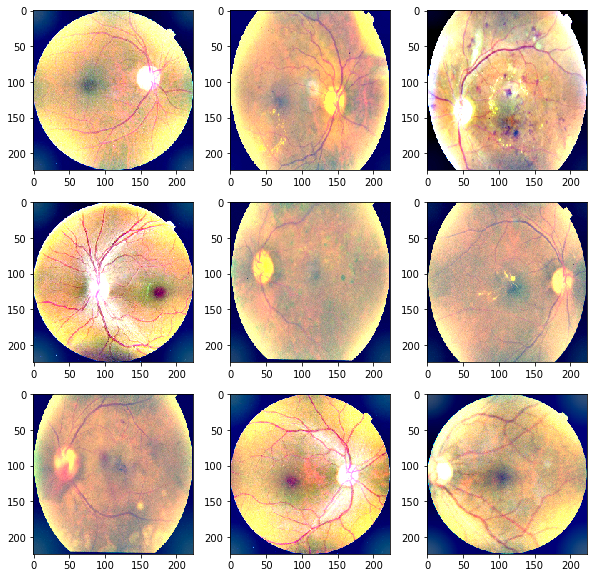

In [8]:
fig, axes = plt.subplots(3,3,figsize=(10,10))
selection = np.random.choice(train_df.index, size=9, replace=False)
images = '../input/aptos2019-blindness-detection/train_images/'+train_df.loc[selection]['id_code']+'.png'
for image, axis in zip(images, axes.ravel()):
    img = preprocess_img(image)
    axis.imshow(img)

In [9]:
def circle_crop(img):
    circle_img = np.zeros((IMG_SIZE, IMG_SIZE), np.uint8)
    cv2.circle(circle_img, ((int)(IMG_SIZE/2),(int)(IMG_SIZE/2)), int(IMG_SIZE/2), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    return img

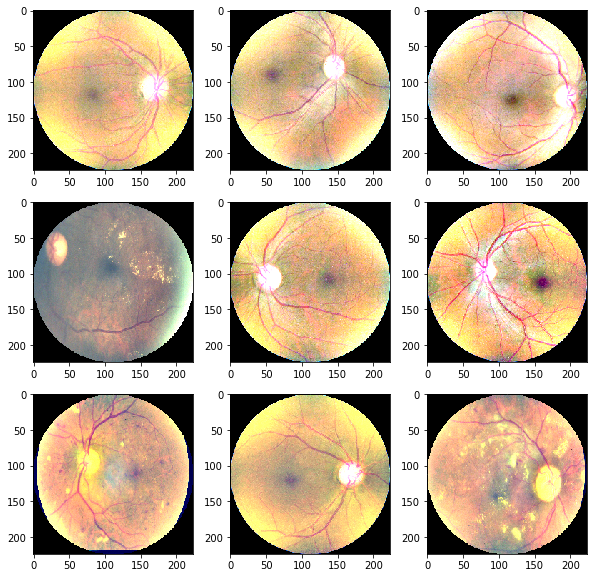

In [10]:
fig, axes = plt.subplots(3,3,figsize=(10,10))
selection = np.random.choice(train_df.index, size=9, replace=False)
images = '../input/aptos2019-blindness-detection/train_images/'+train_df.loc[selection]['id_code']+'.png'
for image, axis in zip(images, axes.ravel()):
    img = circle_crop(preprocess_img(image))
    axis.imshow(img)

In [11]:
N = train_df.shape[0]
train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
for i, image_id in enumerate(tqdm(train_df['id_code'])):
    train[i,:,:,:] = circle_crop(preprocess_img('../input/aptos2019-blindness-detection/train_images/'+image_id+'.png'))

100%|██████████| 3662/3662 [13:15<00:00,  4.30it/s]


In [12]:
N = test_df.shape[0]
test = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
for i, image_id in enumerate(tqdm(test_df['id_code'])):
    test[i,:,:,:] = circle_crop(preprocess_img('../input/aptos2019-blindness-detection/test_images/'+image_id+'.png'))

100%|██████████| 1928/1928 [03:59<00:00,  5.28it/s]


In [13]:
X_train, X_val, y_train, y_val = train_test_split(train, train_df['diagnosis'], test_size=0.15, random_state=42)

In [14]:
BATCH_SIZE = 32

In [15]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        zoom_range=[0.9, 1.0],
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        rotation_range=120
    )

In [16]:
val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [17]:
train_gen = train_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [18]:
val_gen = val_data_generator.flow(X_val, y_val, batch_size=BATCH_SIZE)

In [23]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

94658560/94653016 [==============================] - 2s 0us/step


In [24]:
model = tf.keras.Sequential([
    resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='relu')
])

In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.hdf5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

In [26]:
optimizer = tf.keras.optimizers.Adam(lr=0.00005)

In [27]:
model.compile(optimizer=optimizer, loss='mse')

In [29]:
steps_per_epoch = int(np.ceil(X_train.shape[0]/BATCH_SIZE))
val_steps_per_epoch = int(np.ceil(X_val.shape[0]/BATCH_SIZE))

In [30]:
history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=steps_per_epoch, 
                              validation_steps=val_steps_per_epoch, callbacks=[checkpoint], epochs=25)

Epoch 1/25
97/98 [============================>.] - ETA: 0s - loss: 2.1441
Epoch 00001: val_loss improved from inf to 2.17758, saving model to model_weights.hdf5
98/98 [==============================] - 71s 726ms/step - loss: 2.1367 - val_loss: 2.1776
Epoch 2/25
97/98 [============================>.] - ETA: 0s - loss: 1.6100
Epoch 00002: val_loss improved from 2.17758 to 1.12857, saving model to model_weights.hdf5
98/98 [==============================] - 39s 398ms/step - loss: 1.6133 - val_loss: 1.1286
Epoch 3/25
97/98 [============================>.] - ETA: 0s - loss: 1.3470
Epoch 00003: val_loss improved from 1.12857 to 1.02501, saving model to model_weights.hdf5
98/98 [==============================] - 41s 419ms/step - loss: 1.3387 - val_loss: 1.0250
Epoch 4/25
97/98 [============================>.] - ETA: 0s - loss: 1.2078
Epoch 00004: val_loss improved from 1.02501 to 0.51773, saving model to model_weights.hdf5
98/98 [==============================] - 40s 412ms/step - loss: 1.2096

In [41]:
prediction = model.predict(test)

In [64]:
for i, pred in enumerate(prediction):
    if pred < 0.5:
        prediction[i] = 0
    elif pred < 1.5:
        prediction[i] = 1
    elif pred < 2.5:
        prediction[i] = 2
    elif pred < 3.5:
        prediction[i] = 3
    else:
        prediction[i] = 4

def detail(j):
    if(prediction[j] == 0):
        print("Không thấy tổn thương")
        print("Tái khám sau 1-2 năm")
    if(prediction[j] == 1):
        print("Chỉ có các vi phình mạch")
        print("Tái khám sau 6-12 tháng")
    if(prediction[j] == 2):
        print("Có vi phình mạch và tổn thương khác nhưng ở mức độ nhẹ")
        print("Tái khám sau 3-6 tháng")
    if(prediction[j] == 3):
        print("Xuất huyết trong võng mạc/Tĩnh mạch giãn ngoằn ngoèo/Có bất thường vi mạch trong võng mạc")
        print("Tái khám sau <3 tháng")
    if(prediction[j] == 4):
        print("Tân mạch/Xuất huyết dịch kính trước võng mạc")
        print("Tái khám sau <1 tháng")

In [65]:
prediction = np.squeeze(prediction.astype(np.int8))

In [72]:
print(prediction[1927])
detail(1927)

IndexError: index 1927 is out of bounds for axis 0 with size 224

In [67]:
print(prediction[1])
detail(1)

3
Xuất huyết trong võng mạc/Tĩnh mạch giãn ngoằn ngoèo/Có bất thường vi mạch trong võng mạc
Tái khám sau <3 tháng


In [71]:
print(prediction[2])
detail(2)

2
Có vi phình mạch và tổn thương khác nhưng ở mức độ nhẹ
Tái khám sau 3-6 tháng


In [52]:
scores = model.evaluate(X_val, y_val, verbose=1)
print(scores)

550/550 [==============================] - 1s 2ms/sample - loss: 0.3496
0.3496391931447116


In [ ]:
sample = pd.read_csv("../input/aptos2019-blindness-detection/sample_submission.csv")
sample.diagnosis = prediction
sample.to_csv("submission.csv", index=False)